# Unit Testing of Time-Mapping Module

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotnine as p9

## Set-up Time-Mapping Module

`CumsumMapping` copy-pasted from 'bionetwork.py' and `soft_index` copy-pasted from 'train.py'. `add_hooks` is a helper function to add hooks to a model in order to visualize the gradients of the model. 

In [2]:
class CumsumMapping(nn.Module):
    def __init__(self, bionet_params: dict, K: int = 8):
        """
        Parameter
        ----------
        bionet_params : Dict[str, float]
            training parameters for the model, by default None
            Key values include:
                - 'max_steps': maximum number of time steps of the RNN, by default 300
                - 'tolerance': threshold at which to break RNN; based on magnitude of change of updated edge weight values, by default 1e-5
                - 'leak': parameter to tune extent of leaking, analogous to leaky ReLU, by default 0.01
                - 'spectral_target': _description_, by default np.exp(np.log(params['tolerance'])/params['target_steps'])
                - 'exp_factor': _description_, by default 20
        K : Int
            Number of training time points
        """
        super().__init__()
        self.L = bionet_params['max_steps']
        self.K = K
        
        # Initialize K raw parameters for increments.
        # We set the first element to a very low value (e.g., -3) so that softplus gives a small number,
        # and initialize the others to a constant so that softplus outputs ~1.
        self.delta_raw = nn.Parameter(torch.empty(K))
        nn.init.constant_(self.delta_raw, 0.541)  # so softplus(0.541) ≈ 1.0
        with torch.no_grad():
            self.delta_raw[0] = -3.0  # so softplus(-3.0) ≈ 0.05
        
        # Learnable parameter for the upper bound.
        # We want u to lie in (0, L), so we use a sigmoid scaling.
        self.u_raw = nn.Parameter(torch.tensor(0.0))  # initial u ~ L * sigmoid(0)=L/2
        
        # Learnable nonlinearity parameter alpha.
        # Initialize to a negative value to bias more anchors toward the beginning.
        self.alpha = nn.Parameter(torch.tensor(-1.0))
    
    def forward(self):
        """
        Returns
        -------
        mapping : torch.Tensor of shape (K,)
            Continuous mapping indices that lie in [0, u],
            where u is learnable and u < L.
        """
        L = self.L
        
        # Compute learnable upper bound u in (0, L)
        u = L * torch.sigmoid(self.u_raw)
        
        # Compute raw anchors from delta_raw:
        deltas = F.softplus(self.delta_raw)   # ensure positive increments
        anchors = torch.cumsum(deltas, dim=0)   # monotonic increasing
        # Shift so the first anchor is zero:
        anchors_shifted = anchors - anchors[0]
        
        # Normalize anchors to [0,1]:
        normalized = anchors_shifted / (anchors_shifted[-1] + 1e-8)
        
        # Apply a nonlinear mapping function:
        # mapping(x) = u * (exp(alpha*x) - 1) / (exp(alpha) - 1)
        # If alpha is near zero, fall back to linear mapping.
        eps = 1e-6
        if torch.abs(self.alpha) < eps:
            mapping = u * normalized
        else:
            mapping = u * (torch.exp(self.alpha * normalized) - 1) / (torch.exp(self.alpha) - 1)
        
        # Enforce that the mapping values are less than L.
        mapping = torch.clamp(mapping, 0, L - 1)
        return mapping


def soft_index(Y: torch.Tensor, indices: torch.Tensor):
    """
    Differentiably sample hidden states from Y using linear interpolation.
    
    Parameters
    ----------
    Y : torch.Tensor
        Tensor of shape (batch, L, feat) (here, L is the number of time points).
    indices : torch.Tensor
        Continuous mapping indices of shape (K,) in [0, L-1].
    
    Returns
    -------
    Y_selected : torch.Tensor
        Tensor of shape (batch, K, feat) with the interpolated values.
    time_idx : torch.Tensor
        Approximate (rounded) indices for monitoring.
    """
    batch, L, feat = Y.shape
    K = indices.shape[0]
    floor_idx = torch.floor(indices).long()       # shape (K,)
    ceil_idx = torch.clamp(floor_idx + 1, max=L - 1)  # shape (K,)
    weight = (indices - floor_idx.float()).view(1, -1, 1)  # shape (1, K, 1)
    
    floor_idx_full = floor_idx.view(1, -1, 1).expand(batch, -1, feat)
    ceil_idx_full = ceil_idx.view(1, -1, 1).expand(batch, -1, feat)
    
    Y_floor = torch.gather(Y, 1, floor_idx_full)
    Y_ceil = torch.gather(Y, 1, ceil_idx_full)
    
    Y_selected = (1 - weight) * Y_floor + weight * Y_ceil
    time_idx = torch.round((floor_idx + ceil_idx) / 2)
    return Y_selected, time_idx


def add_hooks(module):
    gradients = {}

    def hook_fn(grad, name):
        gradients[name] = grad

    for name, param in module.named_parameters():
        param.register_hook(lambda grad, name=name: hook_fn(grad, name))

    return gradients

## Create test cases

Simulate via a polynomial, square root and sigmoid function a time-series example, subsample it uniformly, exponentially or randomly and test the time-mapping module.

In [3]:
def sim_poly(t):
    """Polynomial: y = t^2"""
    return t**2

def sim_sqrt(t):
    """Square root: y = sqrt(t)"""
    return np.sqrt(t)

def sim_sigmoid(t):
    """Sigmoid: y = 1/(1+exp(-10*(t-0.5)))"""
    return 1/(1+np.exp(-10*(t-0.5)))

def simulate_time_series(func, L=150):
    """Generate a synthetic time series of L points using a function 'func' on t in [0,1]."""
    t = np.linspace(0, 1, L)
    y = func(t)
    y = y.reshape(1, L, 1)  # shape: (1, L, 1)
    return torch.tensor(y, dtype=torch.float32)

def ideal_uniform(L=150, K=8, lower_bound=10.0, upper_bound=100.0):
    """Uniform mapping: evenly spaced indices between lower_bound and upper_bound."""
    return np.linspace(lower_bound, upper_bound, K)

def ideal_exponential(L=150, K=8, a=-2.0, lower_bound=10.0, upper_bound=100.0):
    """Exponential mapping: using the formula: f(x)=lower_bound+(upper_bound-lower_bound)*((exp(a*x)-1)/(exp(a)-1)) for x in [0,1]."""
    x = np.linspace(0, 1, K)
    return lower_bound + (upper_bound - lower_bound) * ((np.exp(a * x) - 1) / (np.exp(a) - 1))

def ideal_random(L=150, K=8):
    """
    Custom random mapping: 1 point at 0, 2 points from [1,50], 2 from [50,100], 2 from [100,150], and 1 at L.
    """
    rng = np.random.default_rng(42)
    part1 = rng.uniform(1, 20, 2)
    part2 = rng.uniform(50, 80, 2)
    part3 = rng.uniform(100, 140, 2)
    mapping = np.concatenate([[0], part1, part2, part3, [L-1]])
    return np.sort(mapping)

In [4]:
# Define the synthetic functions and ideal mappings
sim_funcs = {
    "polynomial": (lambda t: t**2, "Poly"),
    "sqrt": (np.sqrt, "Sqrt"),
    "sigmoid": (lambda t: 1/(1+np.exp(-10*(t-0.5))), "Sigmoid")
}

ideal_mappings = {
    "uniform": (lambda L, K: np.linspace(0, 150, K), "Uniform"),
    "exponential": (lambda L, K: ideal_exponential(L, K, a=3, lower_bound=0.0, upper_bound=150.0), "Exponential"),
    "random": (lambda L, K: ideal_random(L, K), "Random")
}

mapping_records = []
loss_records = []
ts_records = []

def train_mapping_on_single_example(sim_func, ideal_map_fn, num_epochs=1000, lr=1e-2):
    """
    Train the time mapping module on a single synthetic time series.
    
    Parameters:
      sim_func: function; e.g. sim_poly, sim_sqrt, or sim_sigmoid (operates on numpy array t in [0,1])
      ideal_map_fn: function; one of the ideal mapping functions.
      num_epochs: int; number of training epochs.
      lr: float; learning rate.
      
    Returns:
      mapping_history: list of (epoch, [anchor0, ..., anchor_{K-1}])
      loss_history: list of (epoch, loss)
      alpha_history: list of (epoch, alpha)
      final_subsample: dict with keys: 'time' (x positions of subsampled points) and 'value' (corresponding y)
      full_ts: dict with keys: 'time' (np.linspace(0, L-1, L)) and 'value' (simulated full time series)
    """
    L = 150
    K = 8
    # Simulate the full synthetic time series using the provided simulation function
    Y_full = simulate_time_series(sim_func, L=L)  # shape (1, L, 1)
    
    # Compute the ideal mapping indices using the ideal mapping function
    target_mapping = ideal_map_fn(L, K)
    # Use numpy interpolation to sample the synthetic time series at these indices
    Y_full_np = Y_full.squeeze().detach().cpu().numpy()  # shape (L,)
    target_values = np.interp(target_mapping, np.linspace(0, L-1, L), Y_full_np)
    target_values = torch.tensor(target_values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # shape (1, K, 1)
    
    bionet_params = {'max_steps': L}
    mapping_module = CumsumMapping(bionet_params, K=K)
    gradients = add_hooks(mapping_module)
    optimizer = optim.Adam(mapping_module.parameters(), lr=lr)
    
    mapping_history = []
    loss_history = []
    alpha_history = []
    gradient_history = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred_mapping = mapping_module()  # shape (K,)
        Y_pred, _ = soft_index(Y_full, pred_mapping)  # shape (1, K, 1)
        loss = F.mse_loss(Y_pred, target_values)
        loss.backward()
        
        # Capture gradients
        gradients = {name: param.grad.clone().cpu().numpy() for name, param in mapping_module.named_parameters()}
        gradient_history.append((epoch, gradients))
        
        optimizer.step()
        
        mapping_history.append((epoch, pred_mapping.detach().cpu().numpy().copy()))
        loss_history.append((epoch, loss.item()))
        alpha_history.append((epoch, mapping_module.alpha.item()))
    
    # compute final subsampled points
    final_mapping = mapping_module()
    Y_subsampled, _ = soft_index(Y_full, final_mapping)
    full_time = np.linspace(0, L-1, L)
    full_values = Y_full.squeeze().detach().cpu().numpy()
    subsampled_time = final_mapping.detach().cpu().numpy()
    subsampled_values = Y_subsampled.squeeze().detach().cpu().numpy()
    
    final_subsample = {"time": subsampled_time, "value": subsampled_values}
    full_ts = {"time": full_time, "value": full_values}
    return mapping_history, loss_history, alpha_history, gradient_history, final_subsample, full_ts, target_mapping

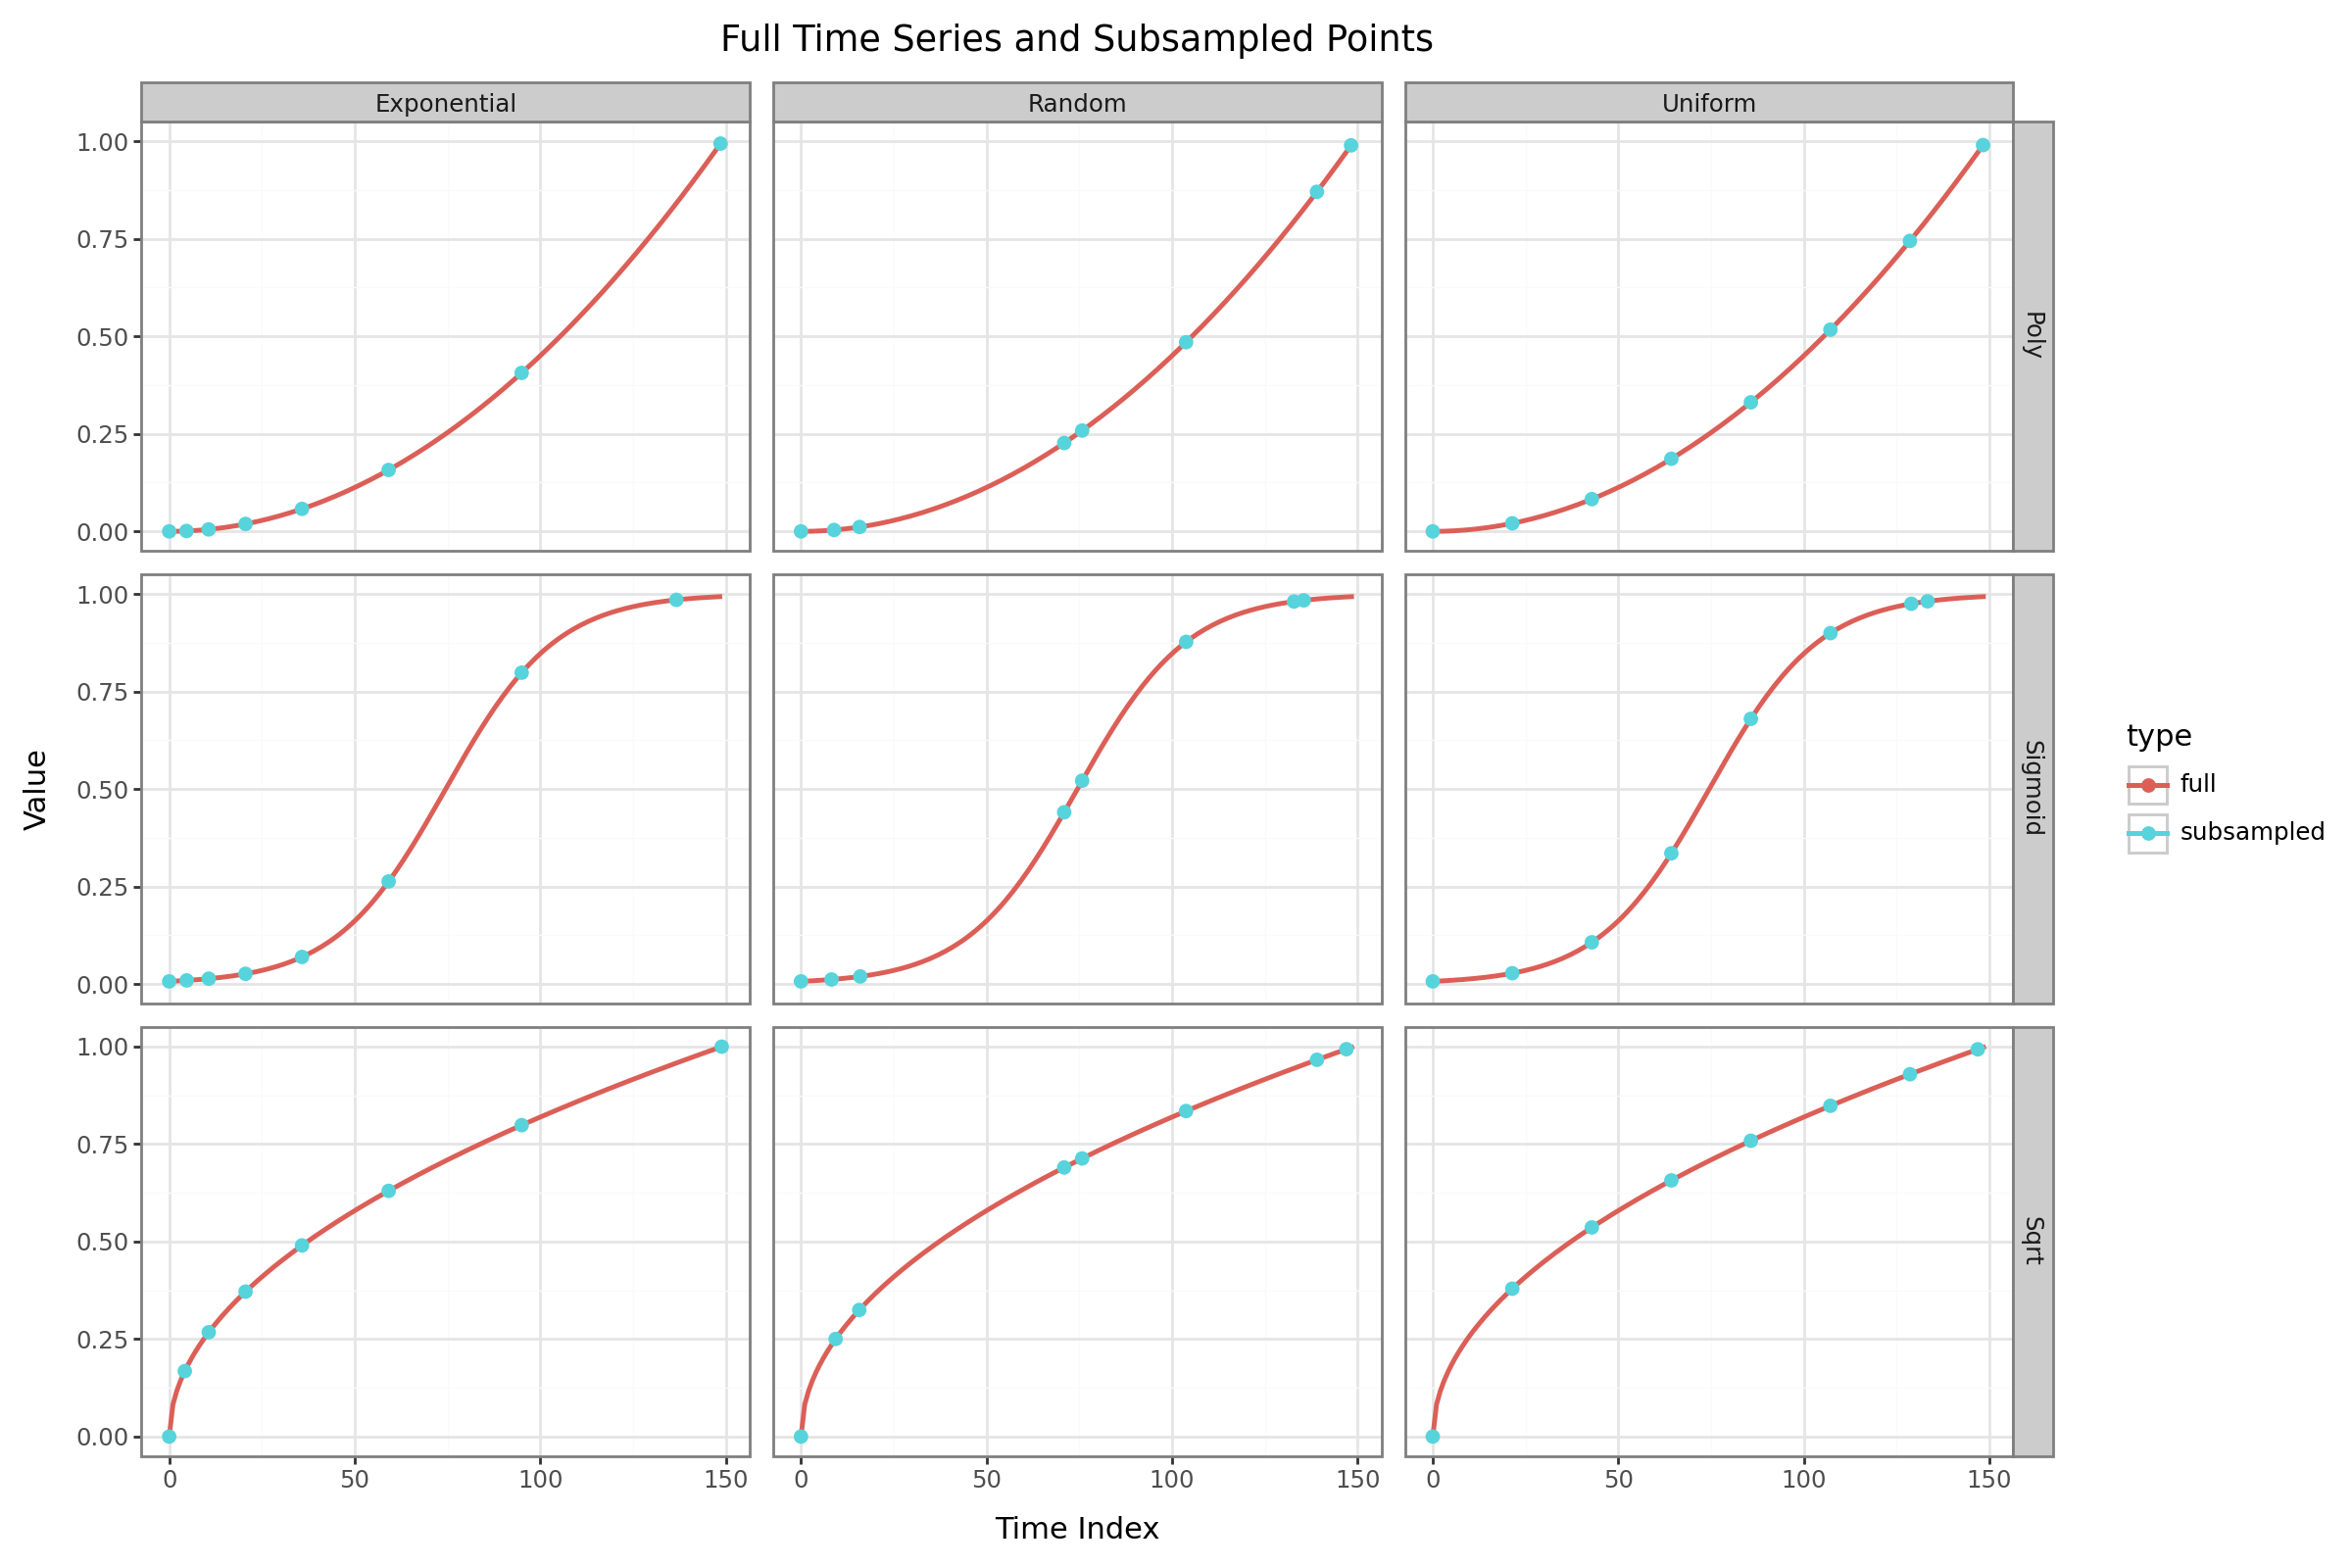

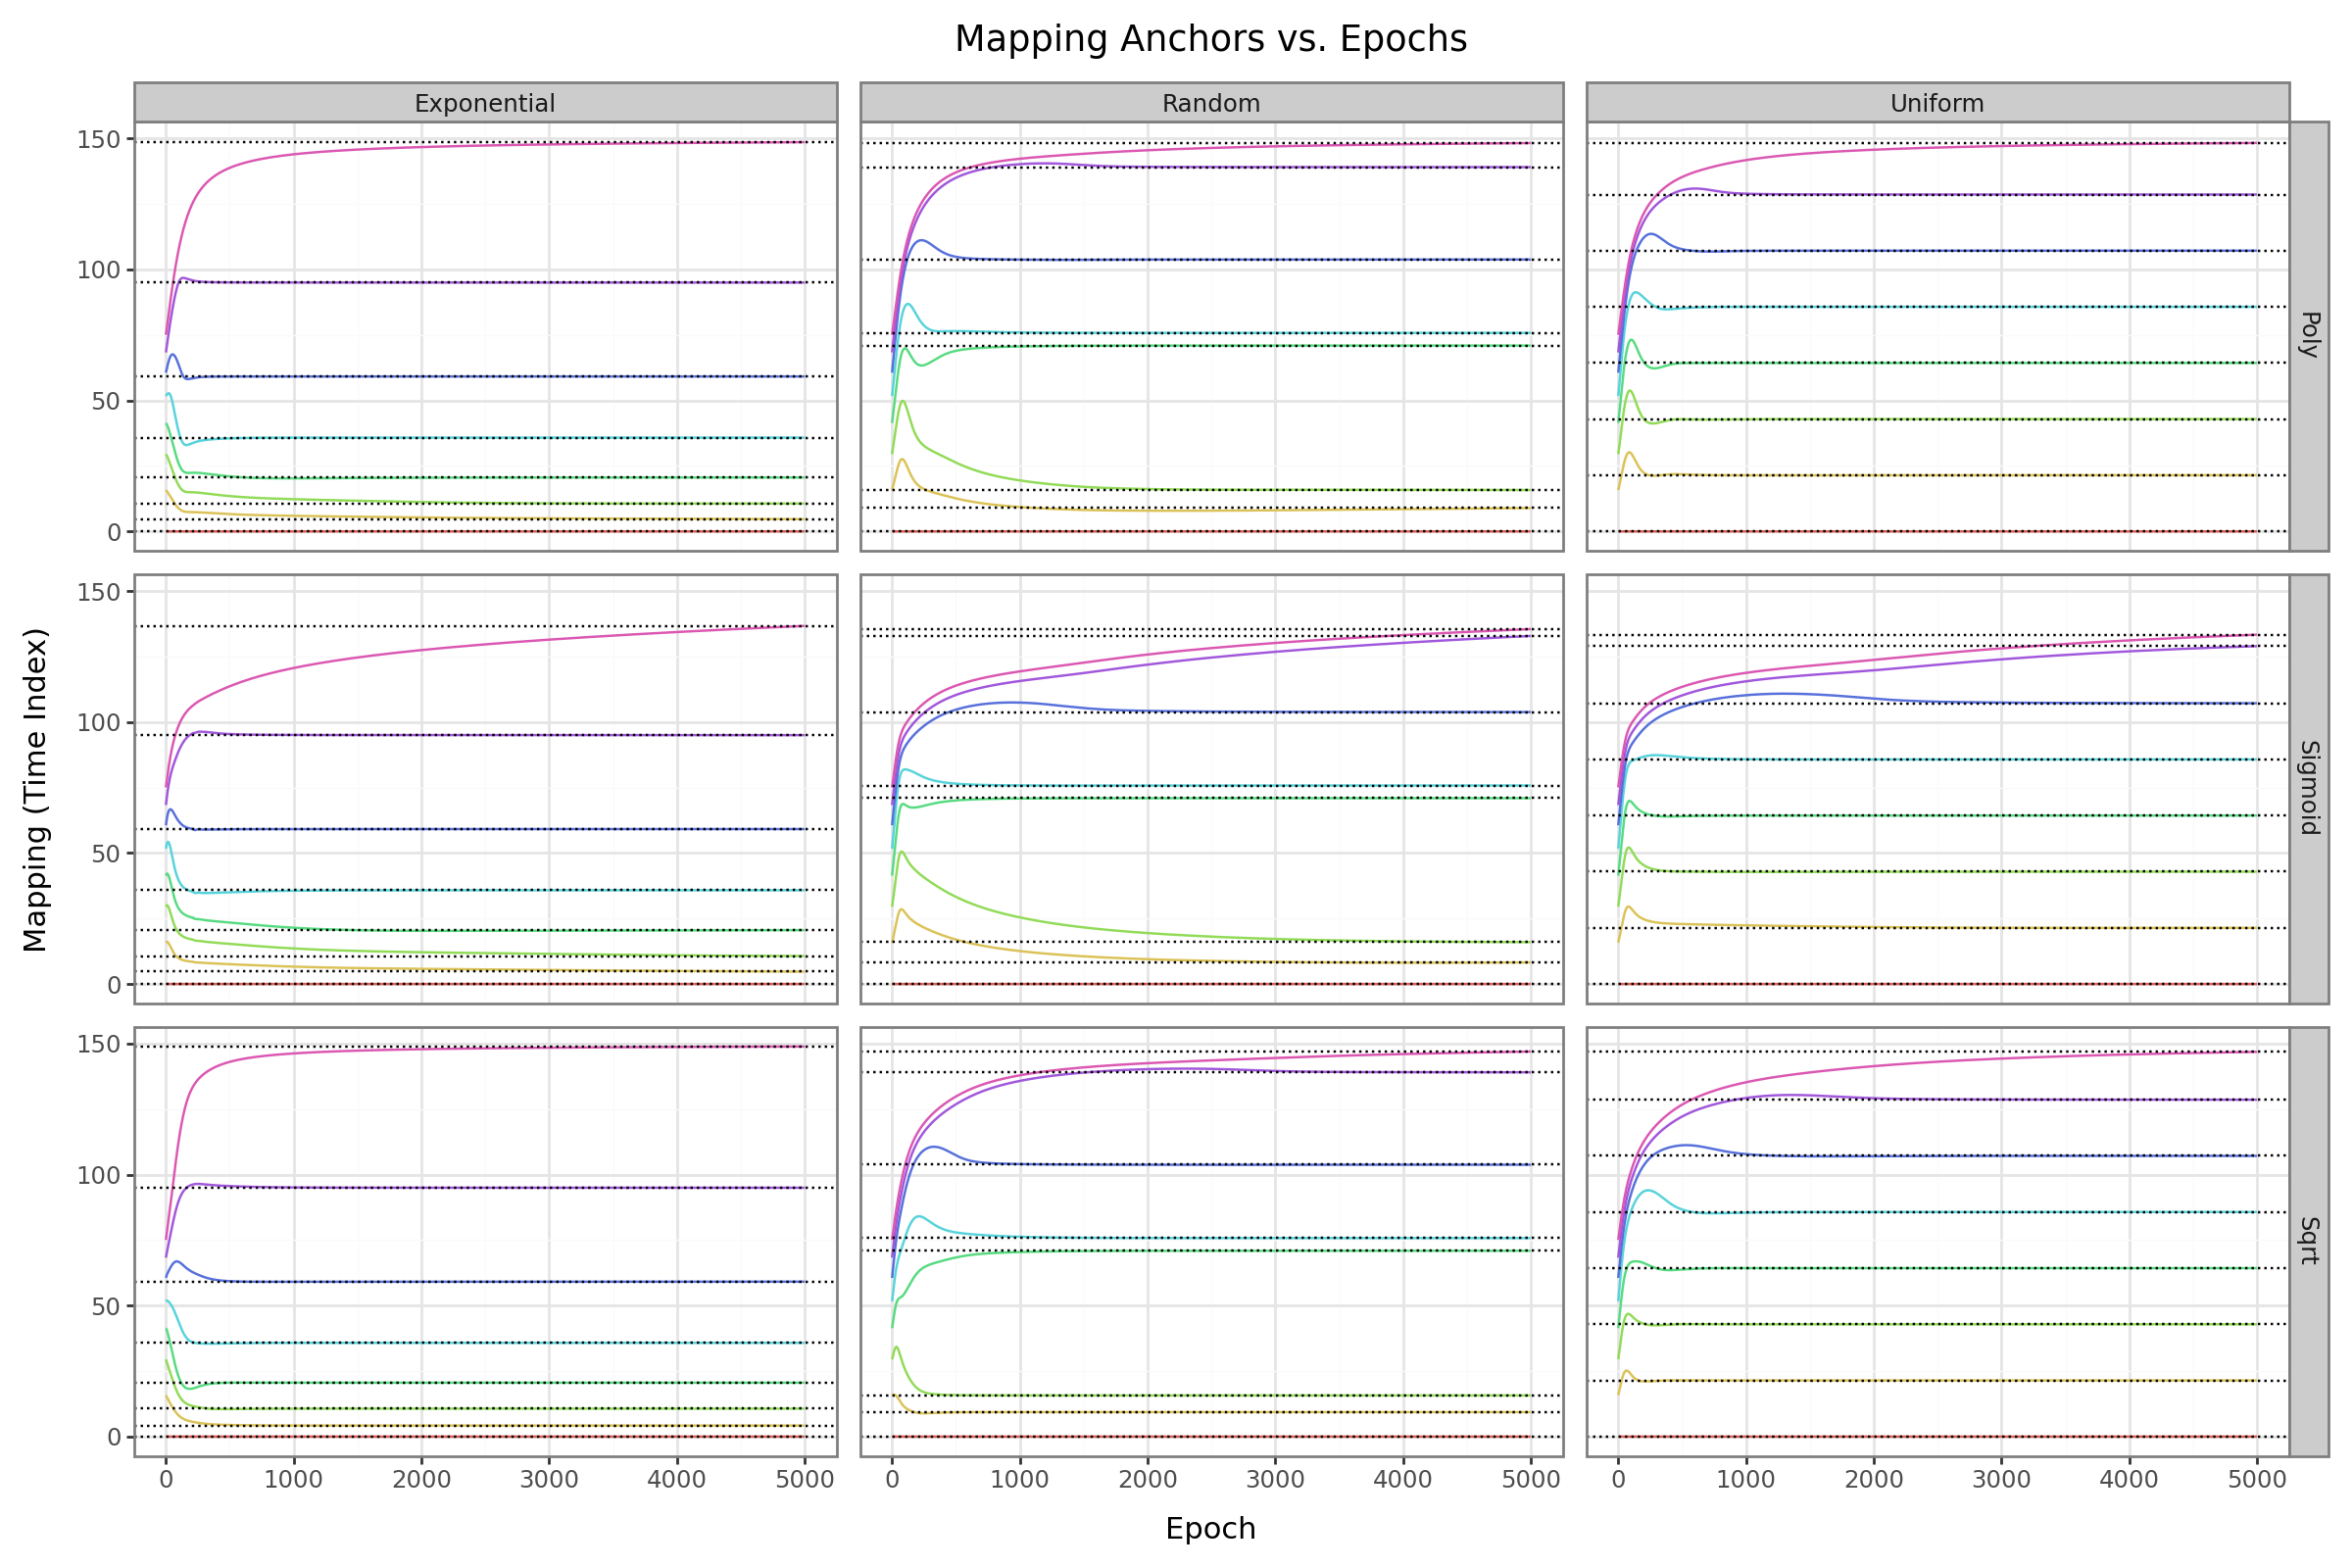

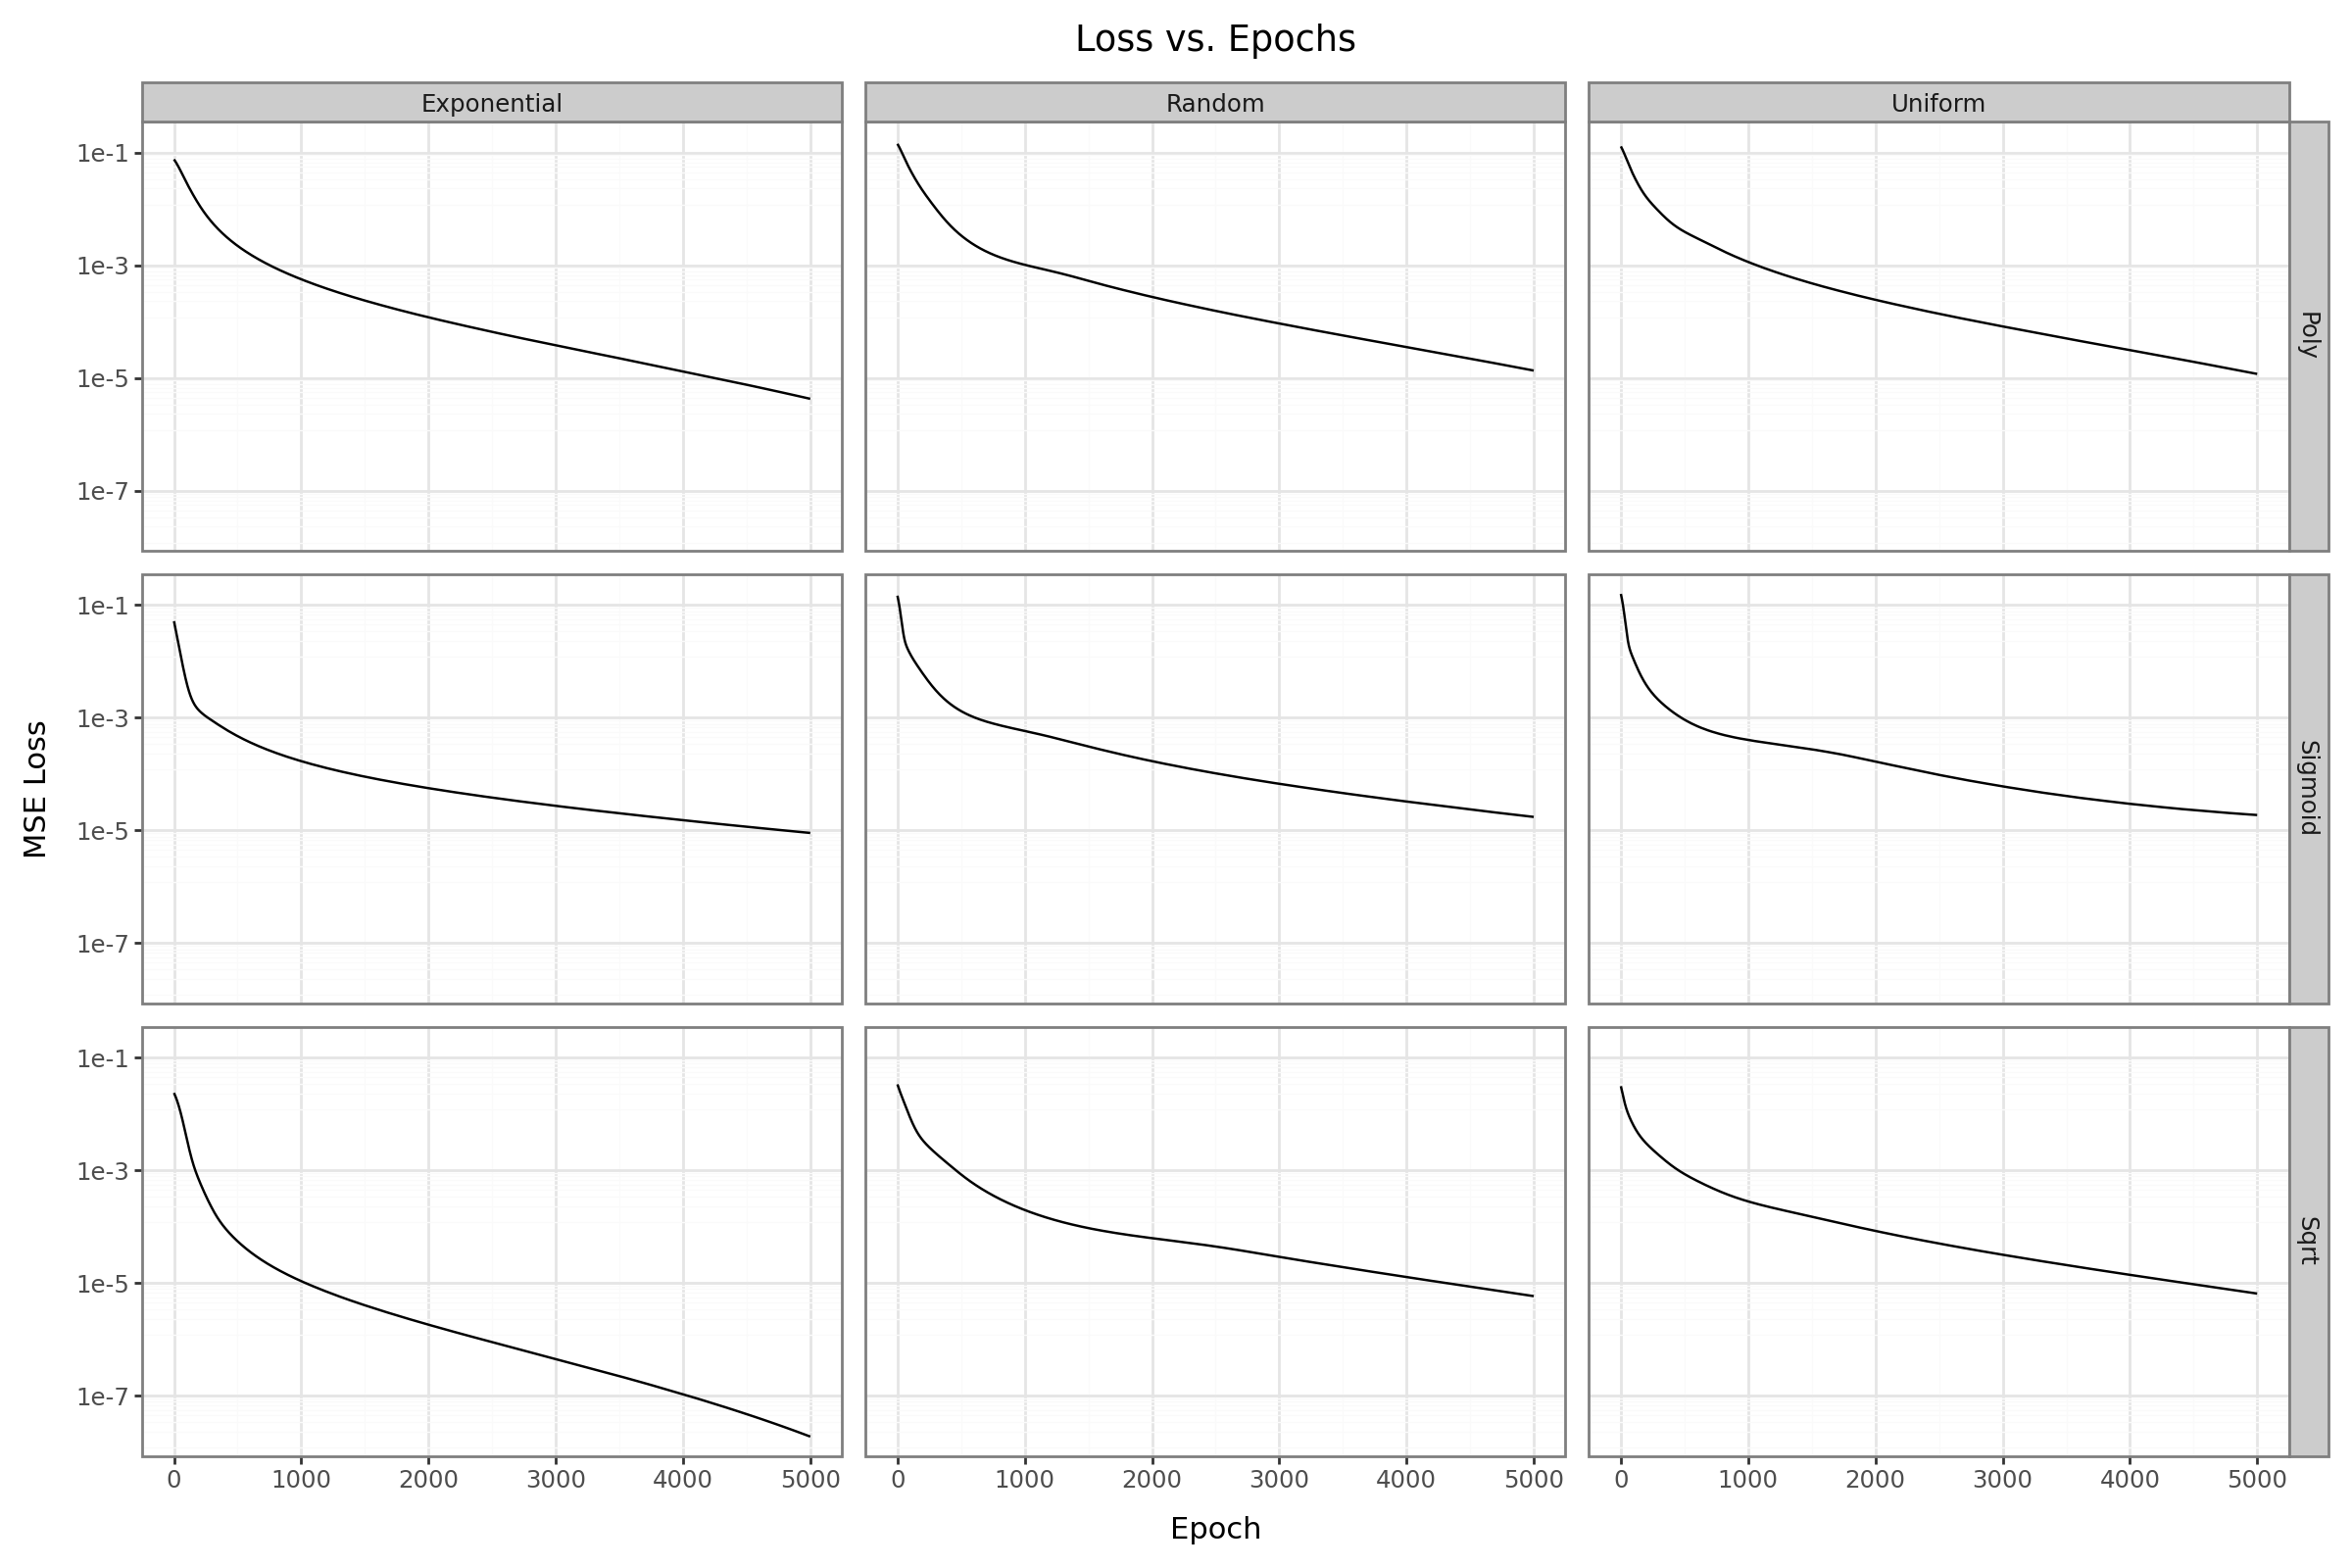

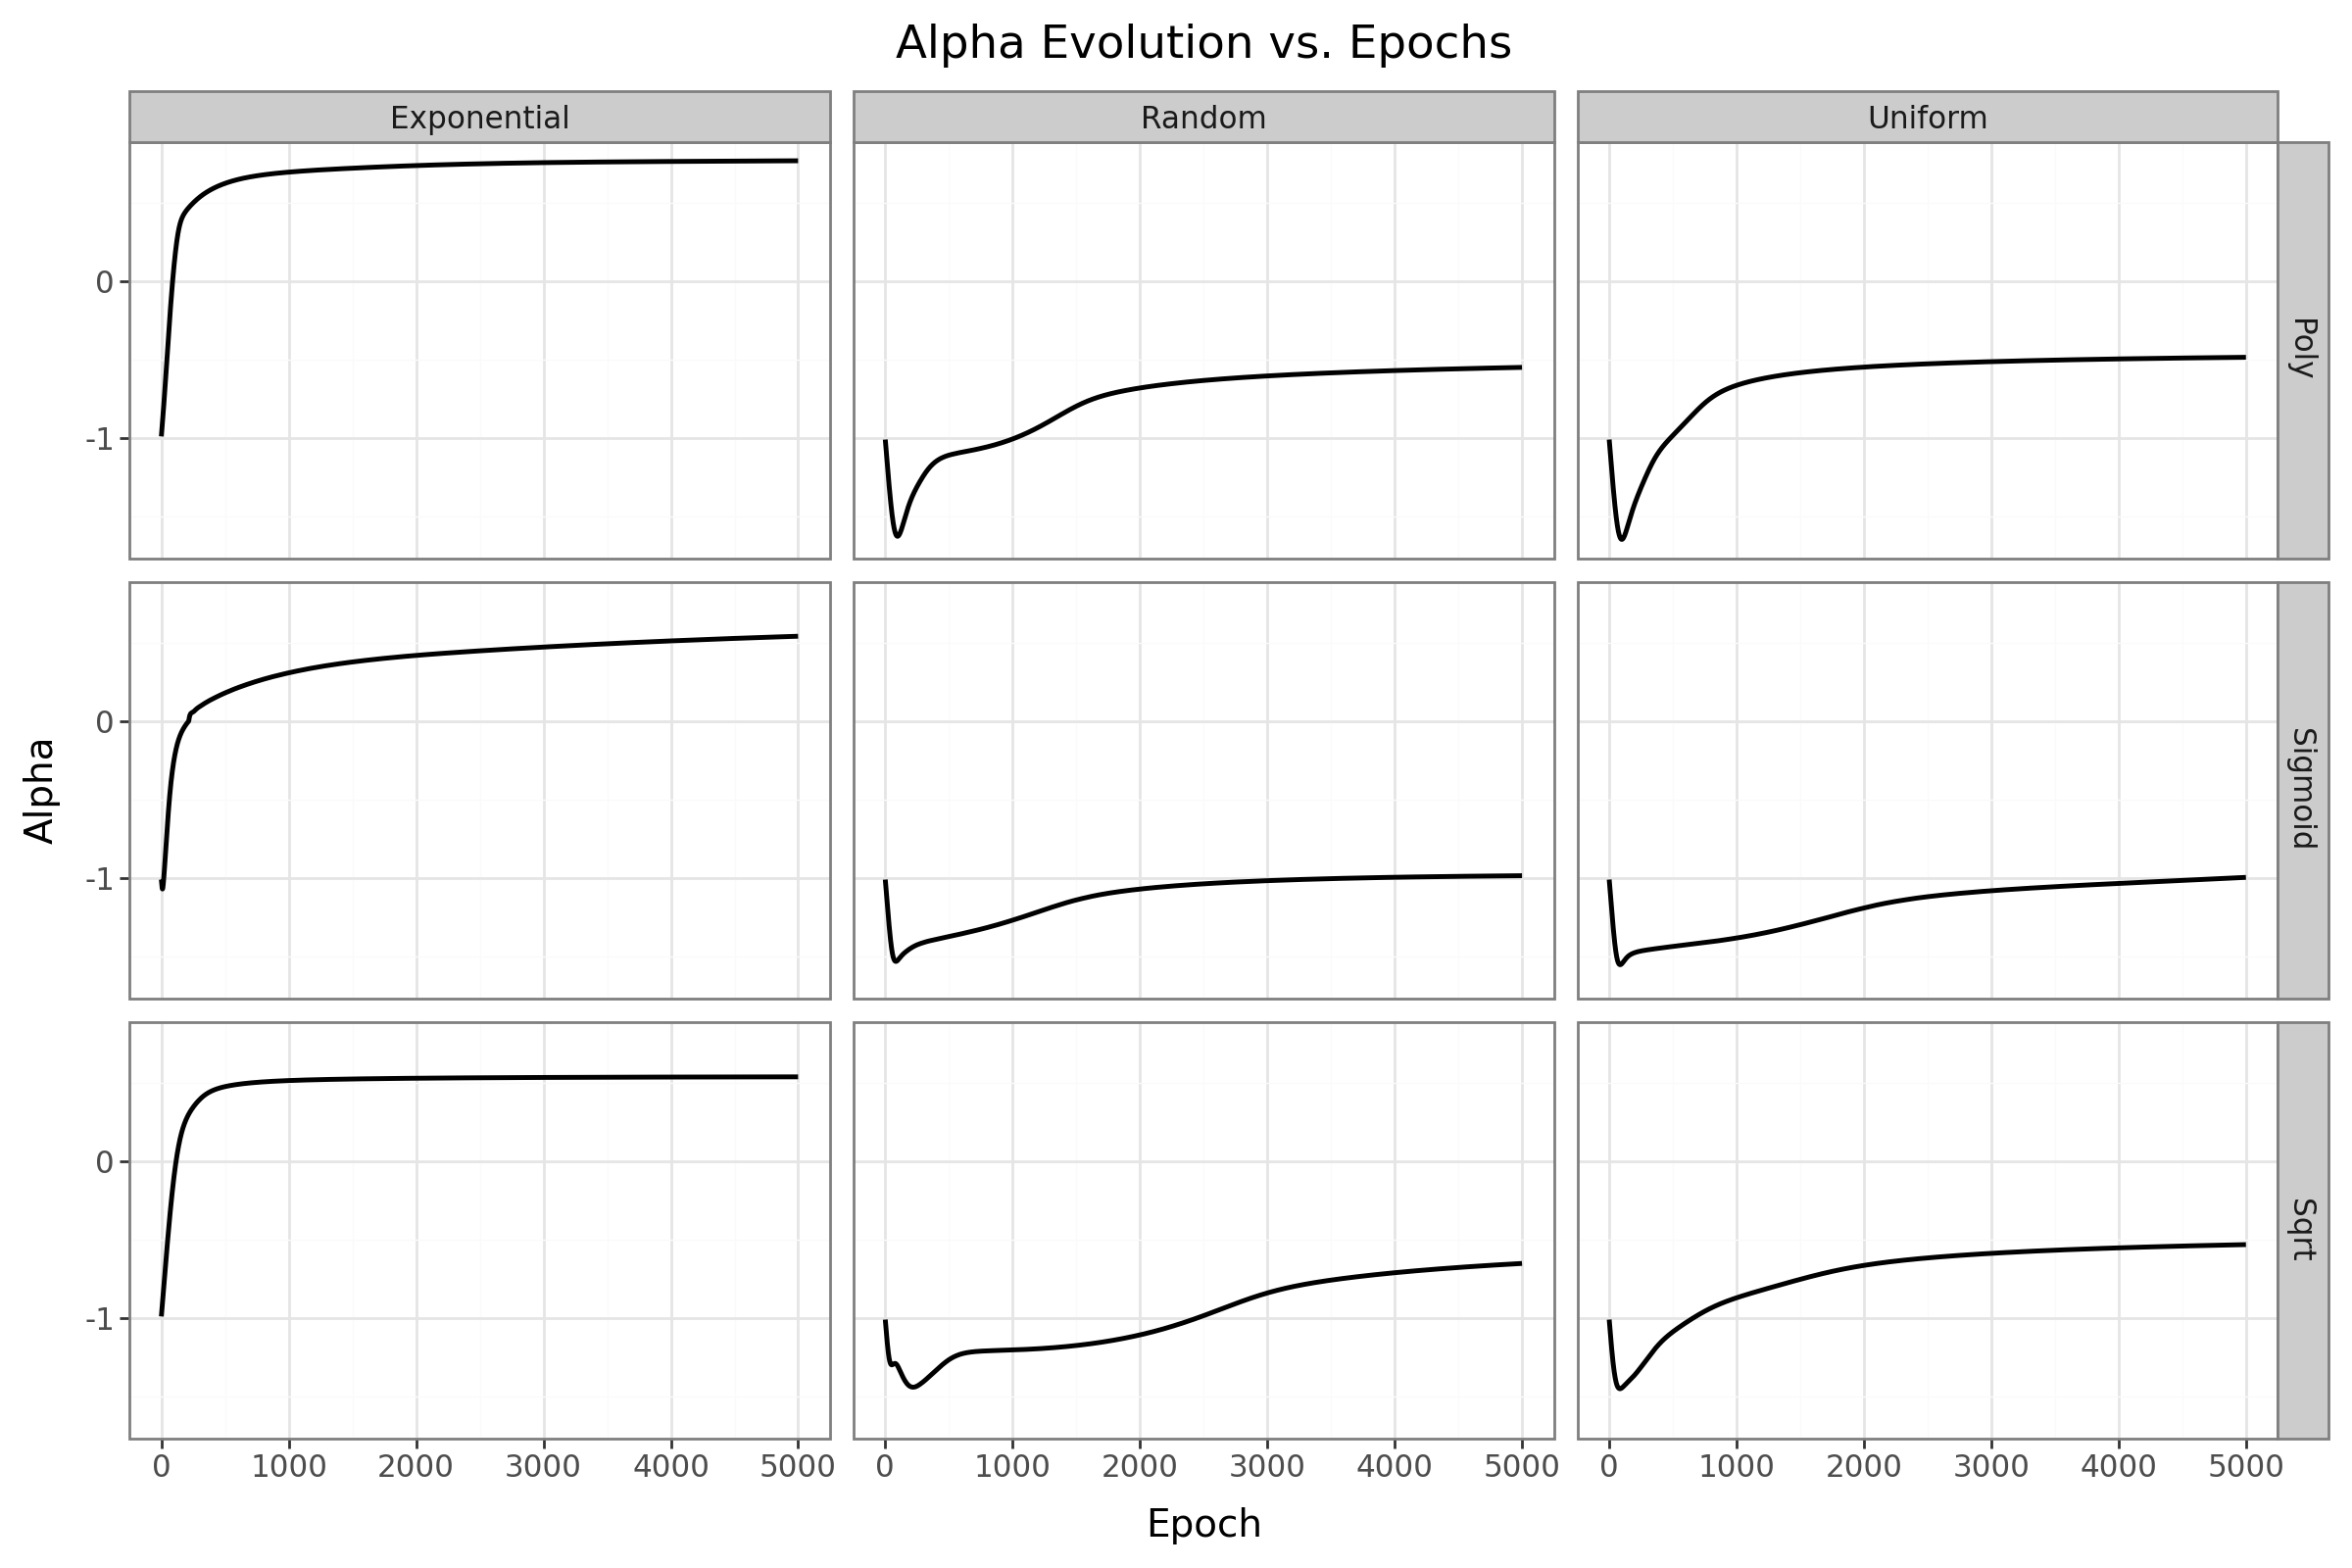

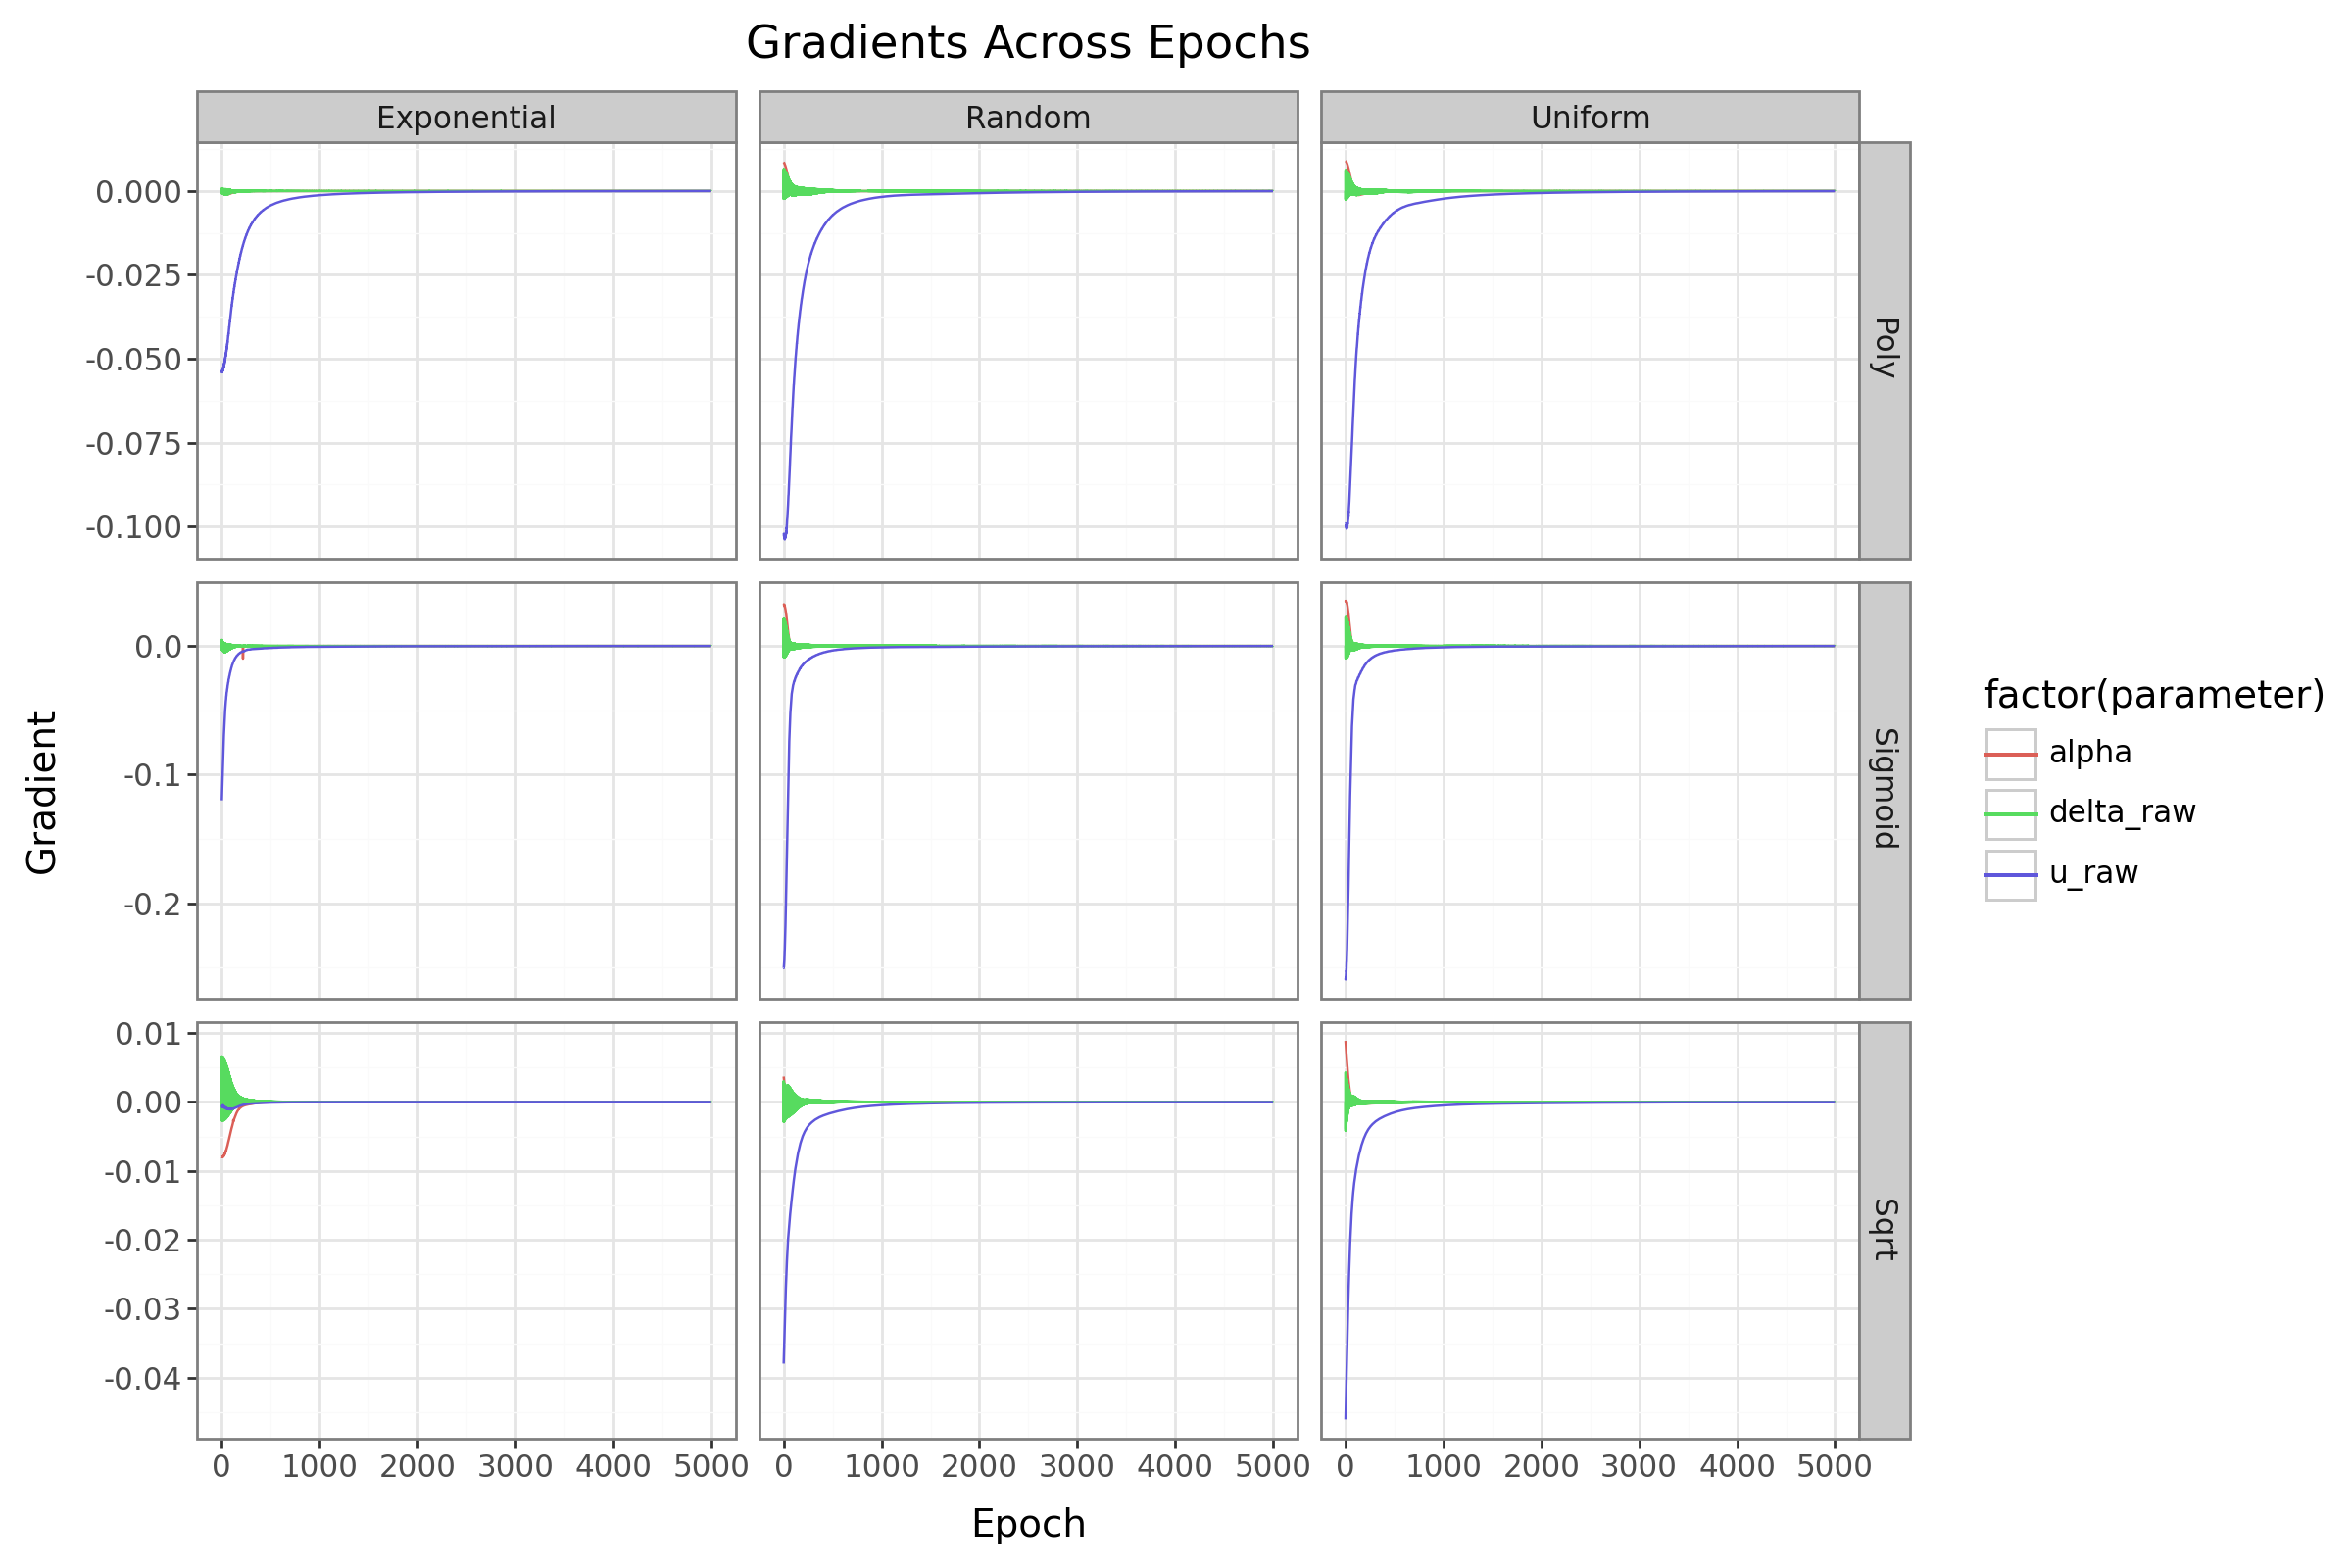

In [8]:
# Loop over all combinations and store results in DataFrames.
results_list = []  # for mapping evolution
ideal_records = []  # for ideal mapping
loss_list = []     # for loss evolution
ts_list = []       # for time series plot
alpha_records = []  # for alpha evolution
gradient_records = []  # for gradient evolution

for sim_key, (sim_func, sim_label) in sim_funcs.items():
    for ideal_key, (ideal_map_fn, ideal_label) in ideal_mappings.items():
        # For ideal_random, ideal_params can be empty
        ideal_params = {"lower_bound":0.0, "upper_bound":140.0} if ideal_key != "random" else {}
        # Train on one synthetic example.
        mapping_hist, loss_hist, alpha_hist, grad_hist, final_subsample, full_ts, target_mapping = train_mapping_on_single_example(sim_func, ideal_map_fn, num_epochs=5000, lr=1e-2)
        
        # Record mapping evolution
        for epoch, anchors in mapping_hist:
            for i, anchor in enumerate(anchors):
                results_list.append({
                    "sim_func": sim_label,
                    "ideal": ideal_label,
                    "epoch": epoch,
                    "anchor_idx": i,
                    "mapping": anchor
                })
        for i, val in enumerate(final_subsample["time"]):
            ideal_records.append({
                "sim_func": sim_label,
                "ideal": ideal_label,
                "anchor_idx": i,
                "ideal_mapping": val
            })
        for epoch, alpha_val in alpha_hist:
            alpha_records.append({
                "sim_func": sim_label,
                "ideal": ideal_label,
                "epoch": epoch,
                "alpha": alpha_val
            })
        # Record loss evolution
        for epoch, l in loss_hist:
            loss_list.append({
                "sim_func": sim_label,
                "ideal": ideal_label,
                "epoch": epoch,
                "loss": l
            })
        # Record time series plot data
        for t, v in zip(full_ts["time"], full_ts["value"]):
            ts_list.append({
                "sim_func": sim_label,
                "ideal": ideal_label,
                "type": "full",
                "time": t,
                "value": v
            })
        # Subsampled points (final mapping)
        for t, v in zip(final_subsample["time"], final_subsample["value"]):
            ts_list.append({
                "sim_func": sim_label,
                "ideal": ideal_label,
                "type": "subsampled",
                "time": t,
                "value": v
            })
        # Record gradients
        for epoch, gradients in grad_hist:
            for name, grad in gradients.items():
                if grad.ndim == 0:
                    gradient_records.append({
                        "epoch": epoch,
                        "parameter": name,
                        "index": 0,
                        "gradient": grad.item(),
                        "sim_func": sim_label,
                        "ideal": ideal_label
                    })
                else:
                    for idx, value in enumerate(grad):
                        gradient_records.append({
                            "epoch": epoch,
                            "parameter": name,
                            "index": idx,
                            "gradient": value,
                            "sim_func": sim_label,
                            "ideal": ideal_label
                        })
        
mapping_df = pd.DataFrame(results_list)
ideal_df = pd.DataFrame(ideal_records)
alpha_df = pd.DataFrame(alpha_records)
loss_df = pd.DataFrame(loss_list)
ts_df = pd.DataFrame(ts_list)
gradient_df = pd.DataFrame(gradient_records)

# Full time series + subsampled points
p1 = (p9.ggplot(ts_df, p9.aes(x="time", y="value", color="type"))
      + p9.geom_line(data=ts_df[ts_df["type"]=="full"], size=1)
      + p9.geom_point(data=ts_df[ts_df["type"]=="subsampled"], size=2)
      + p9.facet_grid("sim_func ~ ideal")
      + p9.labs(title="Full Time Series and Subsampled Points", x="Time Index", y="Value")
      + p9.theme_bw()
      + p9.theme(figure_size=(12, 8)))
p1.show()

# Mapping anchors vs. epochs
p2 = (p9.ggplot(mapping_df, p9.aes(x="epoch", y="mapping", group="anchor_idx", color="factor(anchor_idx)"))
      + p9.geom_line()
      + p9.geom_hline(data=ideal_df, mapping=p9.aes(yintercept="ideal_mapping"), color="black", linetype="dotted")
      + p9.facet_grid("sim_func ~ ideal")
      + p9.labs(title="Mapping Anchors vs. Epochs", x="Epoch", y="Mapping (Time Index)")
      + p9.theme_bw()
      + p9.theme(figure_size=(12, 8), legend_position='none'))
p2.show()

# Loss vs. Epochs
p3 = (p9.ggplot(loss_df, p9.aes(x="epoch", y="loss"))
      + p9.geom_line()
      + p9.facet_grid("sim_func ~ ideal")
      + p9.scale_y_log10()
      + p9.labs(title="Loss vs. Epochs", x="Epoch", y="MSE Loss")
      + p9.theme_bw()
      + p9.theme(figure_size=(12, 8)))
p3.show()

p4 = (p9.ggplot(alpha_df, p9.aes(x="epoch", y="alpha"))
      + p9.geom_line(size=1)
      + p9.facet_grid("sim_func ~ ideal")
      + p9.labs(title="Alpha Evolution vs. Epochs", x="Epoch", y="Alpha")
      + p9.theme_bw(base_size=14)
      + p9.theme(figure_size=(12, 8)))
p4.show()

p5 = (p9.ggplot(gradient_df, p9.aes(x="epoch", y="gradient", color="factor(parameter)"))
      + p9.geom_line()
      + p9.facet_grid("sim_func ~ ideal", scales="free_y")
      + p9.labs(title="Gradients Across Epochs", x="Epoch", y="Gradient")
      + p9.theme_bw(base_size=14)
      + p9.theme(figure_size=(12, 8)))
p5.show()
    
# p1.save("time_series_facets.png", dpi=300)
# p2.save("mapping_evolution_facets.png", dpi=300)
# p3.save("loss_evolution_facets.png", dpi=300)
# p4.save("alpha_evolution_facets.png", dpi=300)
# p5.save("gradients_evolution_facets.png", dpi=300)